In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST, CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision import transforms

from tensorboardX import SummaryWriter
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from ignite.contrib.handlers import ProgressBar

from snip import SNIP

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

LOG_INTERVAL = 20
INIT_LR = 0.1
WEIGHT_DECAY_RATE = 0.0005
EPOCHS = 5
REPEAT_WITH_DIFFERENT_SEED = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def apply_prune_mask(net, keep_masks):

    # Before I can zip() layers and pruning masks I need to make sure they match
    # one-to-one by removing all the irrelevant modules:
    prunable_layers = filter(
        lambda layer: isinstance(layer, nn.Conv2d) or isinstance(
            layer, nn.Linear), net.modules())

    for layer, keep_mask in zip(prunable_layers, keep_masks):
        assert (layer.weight.shape == keep_mask.shape)

        def hook_factory(keep_mask):
            """
            The hook function can't be defined directly here because of Python's
            late binding which would result in all hooks getting the very last
            mask! Getting it through another function forces early binding.
            """

            def hook(grads):
                return grads * keep_mask

            return hook

        # mask[i] == 0 --> Prune parameter
        # mask[i] == 1 --> Keep parameter

        # Step 1: Set the masked weights to zero (NB the biases are ignored)
        # Step 2: Make sure their gradients remain zero
        layer.weight.data[keep_mask == 0.] = 0.
        layer.weight.register_hook(hook_factory(keep_mask))


class LeNet_300_100(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(784, 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x.view(-1, 784)))
        x = F.relu(self.fc2(x))
        return F.log_softmax(self.fc3(x), dim=1)


class LeNet_5(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc3 = nn.Linear(16 * 5 * 5, 120)
        self.fc4 = nn.Linear(120, 84)
        self.fc5 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.fc3(x.view(-1, 16 * 5 * 5)))
        x = F.relu(self.fc4(x))
        x = F.log_softmax(self.fc5(x))

        return x


class LeNet_5_Caffe(nn.Module):
    """
    This is based on Caffe's implementation of Lenet-5 and is slightly different
    from the vanilla LeNet-5. Note that the first layer does NOT have padding
    and therefore intermediate shapes do not match the official LeNet-5.
    """

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 20, 5, padding=0)
        self.conv2 = nn.Conv2d(20, 50, 5)
        self.fc3 = nn.Linear(50 * 4 * 4, 500)
        self.fc4 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.fc3(x.view(-1, 50 * 4 * 4)))
        x = F.log_softmax(self.fc4(x))

        return x


VGG_CONFIGS = {
    # M for MaxPool, Number for channels
    'D': [
        64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M',
        512, 512, 512, 'M'
    ],
}


class VGG_SNIP(nn.Module):
    """
    This is a base class to generate three VGG variants used in SNIP paper:
        1. VGG-C (16 layers)
        2. VGG-D (16 layers)
        3. VGG-like

    Some of the differences:
        * Reduced size of FC layers to 512
        * Adjusted flattening to match CIFAR-10 shapes
        * Replaced dropout layers with BatchNorm
    """

    def __init__(self, config, num_classes=10):
        super().__init__()

        self.features = self.make_layers(VGG_CONFIGS[config], batch_norm=True)

        self.classifier = nn.Sequential(
            nn.Linear(512, 512),  # 512 * 7 * 7 in the original VGG
            nn.ReLU(True),
            nn.BatchNorm1d(512),  # instead of dropout
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.BatchNorm1d(512),  # instead of dropout
            nn.Linear(512, num_classes),
        )

    @staticmethod
    def make_layers(config, batch_norm=False):  # TODO: BN yes or no?
        layers = []
        in_channels = 3
        for v in config:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                if batch_norm:
                    layers += [
                        conv2d,
                        nn.BatchNorm2d(v),
                        nn.ReLU(inplace=True)
                    ]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        x = F.log_softmax(x, dim=1)
        return x


def get_mnist_dataloaders(train_batch_size, val_batch_size):

    data_transform = Compose([transforms.ToTensor()])

    # Normalise? transforms.Normalize((0.1307,), (0.3081,))

    train_dataset = MNIST("_dataset", True, data_transform, download=True)
    test_dataset = MNIST("_dataset", False, data_transform, download=False)

    train_loader = DataLoader(
        train_dataset,
        train_batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True)
    test_loader = DataLoader(
        test_dataset,
        val_batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True)

    return train_loader, test_loader


def get_cifar10_dataloaders(train_batch_size, test_batch_size):

    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])

    train_dataset = CIFAR10('_dataset', True, train_transform, download=True)
    test_dataset = CIFAR10('_dataset', False, test_transform, download=False)

    train_loader = DataLoader(
        train_dataset,
        train_batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True)
    test_loader = DataLoader(
        test_dataset,
        test_batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True)

    return train_loader, test_loader


def mnist_experiment():

    BATCH_SIZE = 100
    LR_DECAY_INTERVAL = 25000

    net = LeNet_300_100().to(device)
    # net = LeNet_5()
#     net = LeNet_5_Caffe().to(device)

    optimiser = optim.SGD(
        net.parameters(),
        lr=INIT_LR,
        momentum=0.9,
        weight_decay=WEIGHT_DECAY_RATE)
    lr_scheduler = optim.lr_scheduler.StepLR(optimiser, 30000, gamma=0.1)

    train_loader, val_loader = get_mnist_dataloaders(BATCH_SIZE, BATCH_SIZE)

    return net, optimiser, lr_scheduler, train_loader, val_loader


def cifar10_experiment():

    BATCH_SIZE = 128
    LR_DECAY_INTERVAL = 30000

    net = VGG_SNIP('D').to(device)

    optimiser = optim.SGD(
        net.parameters(),
        lr=INIT_LR,
        momentum=0.9,
        weight_decay=WEIGHT_DECAY_RATE)
    lr_scheduler = optim.lr_scheduler.StepLR(
        optimiser, LR_DECAY_INTERVAL, gamma=0.1)

    train_loader, val_loader = get_cifar10_dataloaders(BATCH_SIZE,
                                                       BATCH_SIZE)  # TODO

    return net, optimiser, lr_scheduler, train_loader, val_loader


def train():

    writer = SummaryWriter()

    net, optimiser, lr_scheduler, train_loader, val_loader = mnist_experiment()

    # Pre-training pruning using SKIP
    keep_masks = SNIP(net, 1.0, train_loader, device)  # TODO: shuffle?
    apply_prune_mask(net, keep_masks)

    trainer = create_supervised_trainer(net, optimiser, F.nll_loss, device)
    evaluator = create_supervised_evaluator(net, {
        'accuracy': Accuracy(),
        'nll': Loss(F.nll_loss)
    }, device)

    pbar = ProgressBar()
    pbar.attach(trainer)

    @trainer.on(Events.ITERATION_COMPLETED)
    def log_training_loss(engine):
        lr_scheduler.step()
        iter_in_epoch = (engine.state.iteration - 1) % len(train_loader) + 1
        if engine.state.iteration % LOG_INTERVAL == 0:
#             pbar.log_message("Epoch[{}] Iteration[{}/{}] Loss: {:.2f}"
#                   "".format(engine.state.epoch, iter_in_epoch, len(train_loader), engine.state.output))
            writer.add_scalar("training/loss", engine.state.output,
                              engine.state.iteration)

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_epoch(engine):
        evaluator.run(val_loader)

        metrics = evaluator.state.metrics
        avg_accuracy = metrics['accuracy']
        avg_nll = metrics['nll']

        pbar.log_message("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
              .format(engine.state.epoch, avg_accuracy, avg_nll))

        writer.add_scalar("validation/loss", avg_nll, engine.state.iteration)
        writer.add_scalar("validation/accuracy", avg_accuracy,
                          engine.state.iteration)

    trainer.run(train_loader, EPOCHS)

    # Let's look at the final weights
    # for name, param in net.named_parameters():
    #     if name.endswith('weight'):
    #         writer.add_histogram(name, param)

    writer.close()


# if __name__ == '__main__':

#     for _ in range(REPEAT_WITH_DIFFERENT_SEED):
#         train()


In [3]:
net, optimiser, lr_scheduler, train_loader, val_loader = mnist_experiment()

# Pre-training pruning using SKIP
keep_masks = SNIP(net, 0.01, train_loader, device)  # TODO: shuffle?
apply_prune_mask(net, keep_masks)

tensor(2662, device='cuda:0')


In [4]:
params = np.array(list(net.modules())[1].weight.cpu().detach()).reshape(-1)

In [5]:
len(params[params!=0])

1081

(array([67., 57., 49., 52., 54., 43., 60., 57., 52., 59., 51., 56., 59.,
        45., 41., 50., 67., 52., 65., 45.]),
 array([-3.56193781e-02, -3.20556499e-02, -2.84919236e-02, -2.49281973e-02,
        -2.13644709e-02, -1.78007446e-02, -1.42370164e-02, -1.06732901e-02,
        -7.10956287e-03, -3.54583608e-03,  1.78907067e-05,  3.58161749e-03,
         7.14534428e-03,  1.07090715e-02,  1.42727979e-02,  1.78365260e-02,
         2.14002524e-02,  2.49639787e-02,  2.85277050e-02,  3.20914313e-02,
         3.56551595e-02], dtype=float32),
 <a list of 20 Patch objects>)

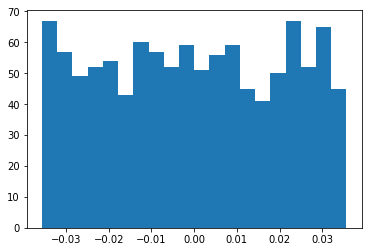

In [6]:
plt.hist(params[params!=0], bins=20)

In [7]:
np.abs(params[params!=0]).min()

0.011775229